In [35]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
#from clickhouse_driver.client import Client

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [36]:
data = "datasets/transactions.csv"
df = pd.read_csv(data, parse_dates=True)
df.head(10)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143
7,2013-01-02,7,1874
8,2013-01-02,8,3250
9,2013-01-02,9,2940


In [37]:


fb = pd.DataFrame(df)
 #, 'транзакции'
fb = fb.loc[fb['store_nbr'] == 1]
fb = fb[['date', 'transactions']] 


In [38]:
fb

,date,transactions
1,2013-01-02,2111
47,2013-01-03,1833
93,2013-01-04,1863
139,2013-01-05,1509
185,2013-01-06,520
...,...,...
83218,2017-08-11,570
83272,2017-08-12,1004
83326,2017-08-13,416
83380,2017-08-14,1733


In [39]:
fb.index = np.arange(len(fb))
fb

,date,transactions
0,2013-01-02,2111
1,2013-01-03,1833
2,2013-01-04,1863
3,2013-01-05,1509
4,2013-01-06,520
...,...,...
1671,2017-08-11,570
1672,2017-08-12,1004
1673,2017-08-13,416
1674,2017-08-14,1733


In [40]:
df = fb[0:363]
df

,date,transactions
0,2013-01-02,2111
1,2013-01-03,1833
2,2013-01-04,1863
3,2013-01-05,1509
4,2013-01-06,520
...,...,...
358,2013-12-27,2022
359,2013-12-28,1070
360,2013-12-29,416
361,2013-12-30,1388


In [41]:
df2 = fb[0:600]
df2

,date,transactions
0,2013-01-02,2111
1,2013-01-03,1833
2,2013-01-04,1863
3,2013-01-05,1509
4,2013-01-06,520
...,...,...
595,2014-08-22,1766
596,2014-08-23,1214
597,2014-08-24,494
598,2014-08-25,1789


In [42]:
df = df.reset_index()

In [43]:
train=df2[:363]
test=df2[363:500]

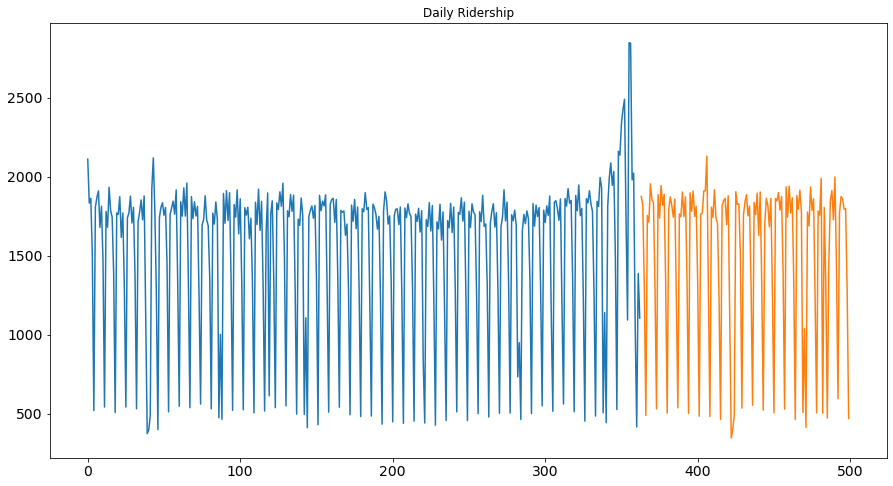

In [45]:
import matplotlib.pyplot as plt
#Строим график
train['transactions'].plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
test['transactions'].plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()

In [46]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

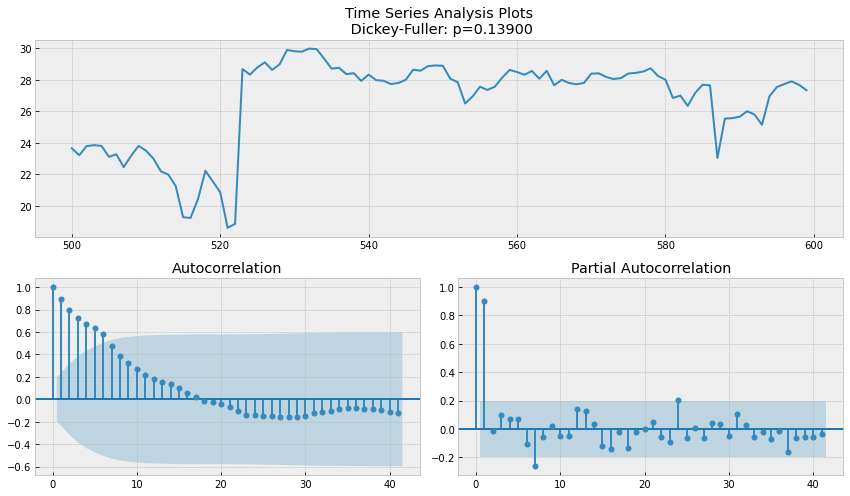

In [39]:
tsplot(test['Open'], lags=41)

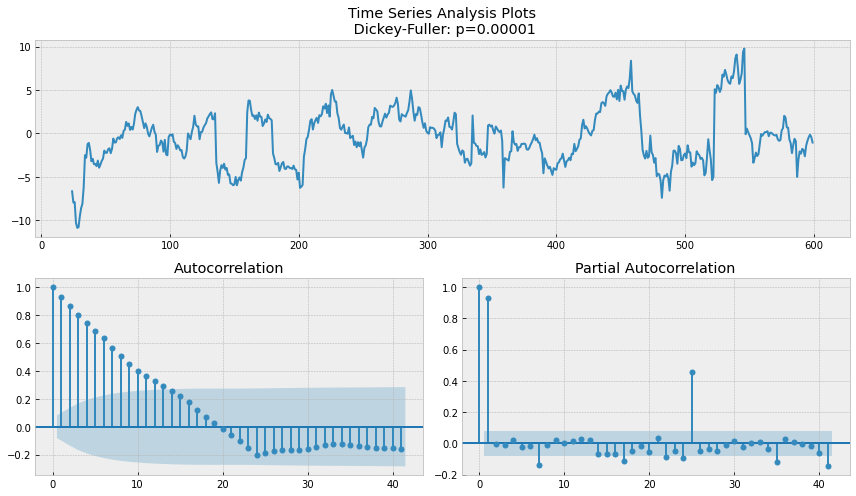

In [40]:
ads_diff = df['Open'] - df['Open'].shift(24)
tsplot(ads_diff[24:], lags=41)

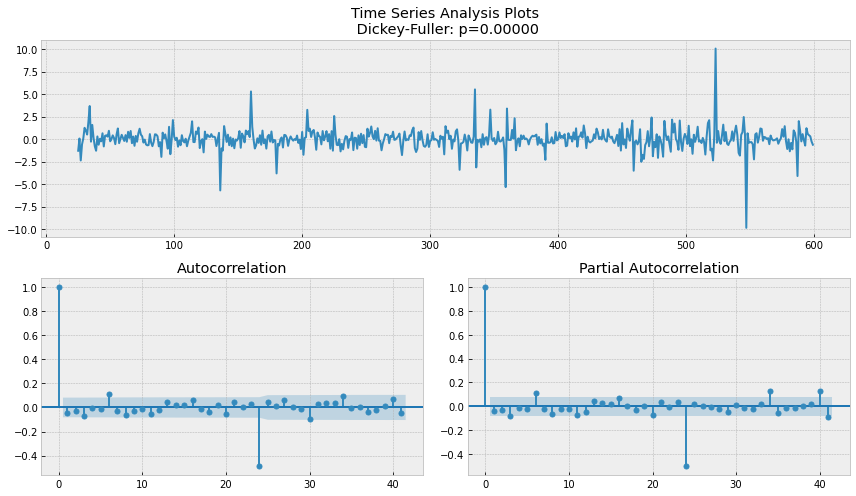

In [41]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=41)

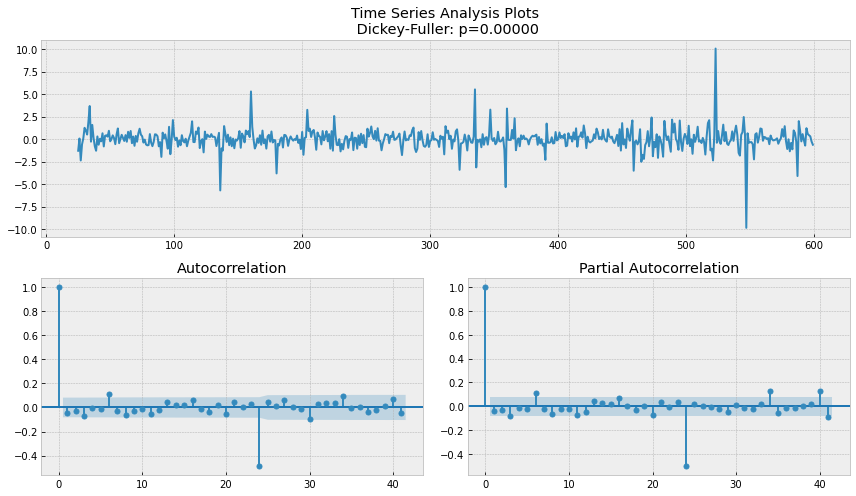

In [42]:
tsplot(ads_diff[24+1:], lags=41)

In [52]:
from itertools import product  
ps = range(2, 6)
#if((sum(df['GMV D-R'][61:90])>1.25*sum(df['GMV D-R'][0:29])) or ((sum(df['GMV D-R'][333:362])>2*sum(df['GMV D-R'][0:29])))):
#    d=1
#else:
#    d=0
d = 1 
qs = range(2,6)
Ps = range(0,2)
D=1 
Qs = 1
s = 28 # season length is still 7

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps)
parameters_list = list(parameters)
len(parameters_list)

1

In [53]:
from tqdm import tqdm_notebook
def optimizeSARIMA(parameters_list, D,Qs, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            #print(parameters_list)
            model=sm.tsa.statespace.SARIMAX(df['transactions'], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, Qs, s)).fit(disp=-1)
        except:
            continue 
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

        #print(results)
    
    print(results)   
    result_table = pd.DataFrame(results)
    #result_table = result_table.reset_index()
    print(result_table)
    result_table.columns = ['parameters', 'aic']
    #result_table=result_table[['parameters', 'aic']]
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table


In [54]:
%%time
result_table = optimizeSARIMA(parameters_list, D,Qs, s)



[[(2, 2, 2), 4629.584224241957]]
           0            1
0  (2, 2, 2)  4629.584224
Wall time: 39.7 s


In [56]:
result_table.head(10)

,parameters,aic
0,"(2, 2, 2)",4629.584224


In [61]:
%%time
# set the parameters that give the lowest AIC
p, q, P = result_table.parameters[1]

best_model=sm.tsa.statespace.SARIMAX(df['transactions'], order=(p, d, q), 
                                        seasonal_order=(P, D, Qs, 28)).fit(disp=-1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       transactions   No. Observations:                  363
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 28)   Log Likelihood               -2303.975
Date:                            Wed, 01 Jun 2022   AIC                           4621.949
Time:                                    01:13:40   BIC                           4648.627
Sample:                                         0   HQIC                          4632.586
                                            - 363                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6780      0.084      8.117      0.000       0.514       0.842
ma.L1         -1.4254      0.387   

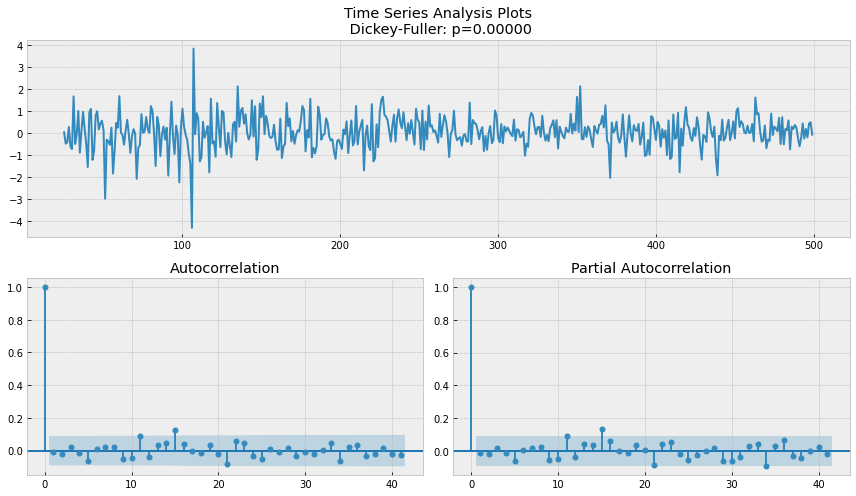

In [28]:
tsplot(best_model.resid[24+1:], lags=41)

In [18]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [66]:
import sklearn.metrics
#from sklearn.metrics import mean_absolute_percentage_error
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['col1','col2','actual']
    #data['actual'][600:720] = fb['Open'][600:720]
    #print(data['actual'] [700])
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][363:] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(df2['transactions'][363:500], forecast[363:500])

    plt.figure(figsize=(15, 7))
    plt.title("Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(df2['transactions'][:550], label="actual")
    plt.legend()
    
    #for i in forecast[:100]:
   #     print(i)
    """print("\n\n\nFact")
    print("April")
    for i in range(254,284):
        #print(f"Prediction on 04 {i-363} by SARIMA - {sum(forecast[i:i+1])}")
        #print(f"Fact on 04 {i-363} - {sum(data.actual[i:i+1])}")
        print(df['GMV D-R'][i]/1000000)
    print("May")
    for i in range(284,315):
        #print(f"Prediction on 05 {i-393} by SARIMA - {sum(forecast[i:i+1])}")
        #print(f"Fact on 05 {i-393} - {sum(data.actual[i:i+1])}")
        print(df['GMV D-R'][i]/1000000)"""
    
    #for i in range(100):
    #    print(forecast[i] - fb['Open'][600+i])
    plt.grid(True);


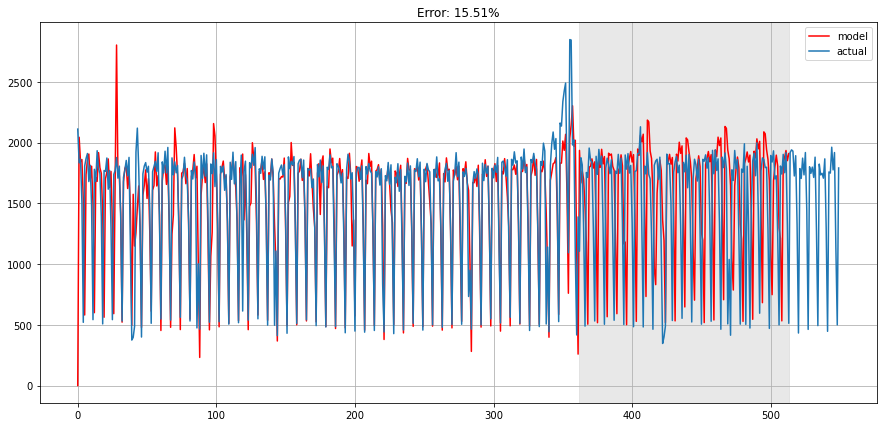

In [67]:
plotSARIMA(df, best_model, 150)

In [ ]:
if(sum(df['GMV D-R'][61:90])>1.3*sum(df['GMV D-R'][0:29])):
    d=1
else:
    d=0
print(d)